In [1]:
using Revise

In [2]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664
┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple, Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs/Docs.jl:240


In [3]:
using PotentialFlow

In [4]:
using CairoMakie
#using Plots
#pyplot()

In [5]:
using LaTeXStrings

In [6]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

### Truth

In [806]:
t = 0.0
δ_true = 0.4

#=
# For placing the vortices randomly
Nv_cluster = 3 #3
Nv_per_cluster = 1 #5
Nv_true = Nv_cluster*Nv_per_cluster 

xr = (-1.5,1.5)
yr = (0.1,1.0)
Γr = (0.0,2.0)


σx = 0.03
σΓ = 0.03
zv, Γv = createclusters(Nv_cluster,Nv_per_cluster,xr,yr,Γr,σx,σΓ,each_cluster_radius=1.5*σx)
=#

#=
Prescribed placement
=#
zv = [0.0+0.75im]
Γv = [1.0]
#zv = [0.0+0.75im,0.75+0.5im]
#Γv = [1.2,1.0]
#zv = [-1.0+0.75im,0.25+0.5im,0.75+0.75im]
#Γv = [1.0,1.2,1.4]
Nv_true = length(zv)

#=
x_true = [-0.7611581857580003,
  0.7266716391085539,
  0.04730897238217636,
  0.4637373841856715,
  0.6347931827658125,
  1.6466841098688845];
  zv, Γv = state_to_positions_and_strengths(x_true)
  Nv_true =  length(zv)
=#


1

### Create sensors

In [807]:
# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle
rsens = 2.0
Nsens = 3
θsens = range(0,2π,length=Nsens+1)
#sens = rsens*exp.(im*θsens[1:end-1]);

# sensors in lines
Nsens = 3
ϵsens = 0.0
lowerrow = range(-1.5,1.5,length=Nsens) .+ (-0.5ϵsens .+ ϵsens*rand(Nsens))*im
#upperrow = range(-2.0,2.0,length=Nsens) .+ 1.0*im
#leftside = im*range(-1.0,3.0,length=Nsens) .- 1.0
#rightside = im*range(-1.0,3.0,length=Nsens) .+ 1.0
sens = vcat(lowerrow,);  #upperrow);

#### Set up the observer for the truth data

In [808]:
config_true = VortexConfig(Nv_true, δ_true,body=LowRankVortex.NoWall)

truez = zv

vort = Vortex.Blob.(zv,Γv,δ_true)
x_true = lagrange_to_state(vort,config_true)

obs_true = PressureObservations(sens,config_true);

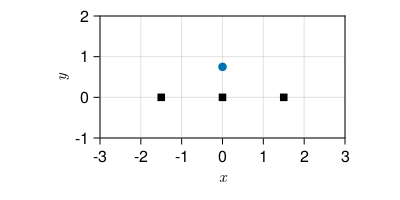

In [809]:
f = Figure(;resolution = (400, 200))
ax = f[1,1] = Axis(f;limits=(-3,3,-1,2), xlabel = L"x",ylabel = L"y", aspect=DataAspect())
show_vortices!(ax,x_true,obs_true)
plot_sensors!(ax,obs_true)
f

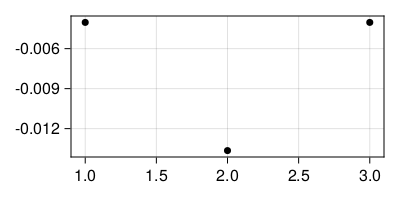

In [810]:
f = Figure(;resolution = (400, 200))
ax = f[1,1] = Axis(f)
ystar = observations(x_true,t,obs_true);
plot_sensor_data!(ax,ystar,obs_true)
f

## Vortex estimation

In [834]:
Nv_estimator = 1
δ = 0.01

config_estimator = VortexConfig(Nv_estimator, δ, body=LowRankVortex.NoWall)

# measurement noise
ϵmeas = 5e-4 #1e-3

# ranges to confine the prior mean to
xr = (-2,2)
yr = (0.01,1.5)
Γr = (0.2,2.0)
bounds = create_state_bounds(xr,yr,Γr,config_estimator);


obs = PressureObservations(sens,config_estimator);

Σϵ = Diagonal(ϵmeas^2*ones(length(sens)));

function my_logp̃(x::Vector)
    logp̃ = normal_loglikelihood(x,t,ystar,Σϵ,obs)
    logp̃ += log_uniform(x,bounds)
end

my_logp̃ (generic function with 1 method)

### MCMC approach

In [835]:
## Parallel tempering ##
# Set the number of chains and the inverse "temperature" of each chain
nchain = 5
β = 3.0.^(range(0,-3,length=nchain));

In [836]:
Ntrial = 10000
propvarX = 0.01^2 # 0.01^2
propvarY = 0.01^2 # 0.01^2
propvarΓ = 0.01^2 # 0.01^2
propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator);

# scale the covariance of each chain by its temperature
propvars = [propvar/β[i] for i = 1:nchain];

In [837]:
#xseed = copy(x_true)
xseed = generate_random_state(xr,yr,Γr,obs.config)
xseeds = [xseed for n = 1:nchain]
#xseeds = [generate_random_state(xr,yr,Γr,obs.config) for n = 1:nchain]

x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,my_logp̃,propvars;β=β,process_state=x->state_filter!(x,obs));

In [838]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.7390521895620876
 0.7364527094581084
 0.7526494701059788
 0.7476504699060188
 0.7328534293141372

In [839]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.2738486842105263
 0.2618855761482675
 0.35141509433962265
 0.2816679779701023

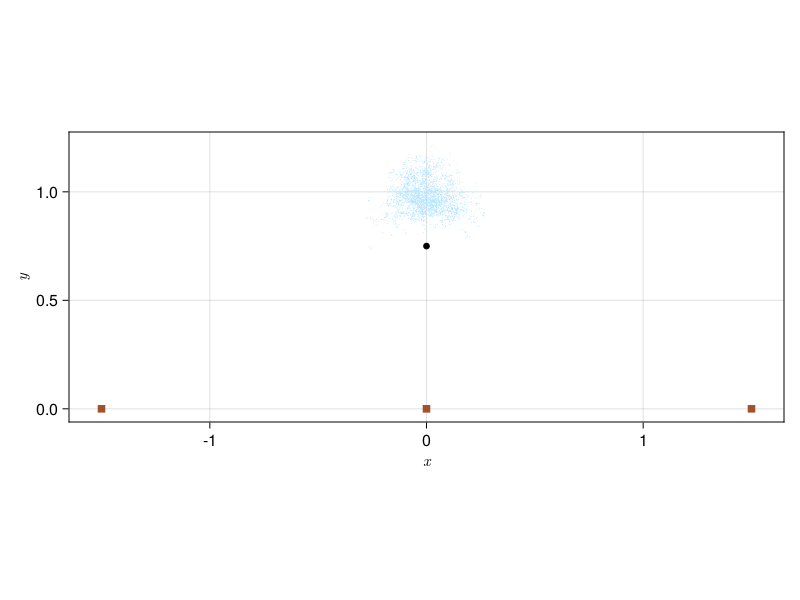

In [840]:
f = Figure()
ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
show_vortex_samples!(ax,x_data[1],obs,nskip=1,color=:lightskyblue1)
scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=8,color=:black,strokewidth=1)
plot_sensors!(ax,obs,color=:sienna)
f

#### Build from the first chain 

In [841]:
β = 3.0.^(range(0,-3,length=nchain));

In [842]:
Ntrial = 400000
propvarX = 0.005^2 # 0.01^2
propvarY = 0.005^2 # 0.01^2
propvarΓ = 0.005^2 # 0.01^2
propvar = state_covariance(propvarX,propvarY,propvarΓ,config_estimator);

propvars = [propvar/β[i] for i = 1:nchain];

In [843]:
xseeds = [x_data[j][:,end] for j = 1:nchain]
x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,my_logp̃,propvars;β=β,process_state=x->state_filter!(x,obs));

In [844]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.8661956690216549
 0.8652556737216314
 0.8617956910215449
 0.8555107224463878
 0.8497707511462442

In [845]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.2575155528797913
 0.2751210955408934
 0.3393141865299614
 0.2940581893134612

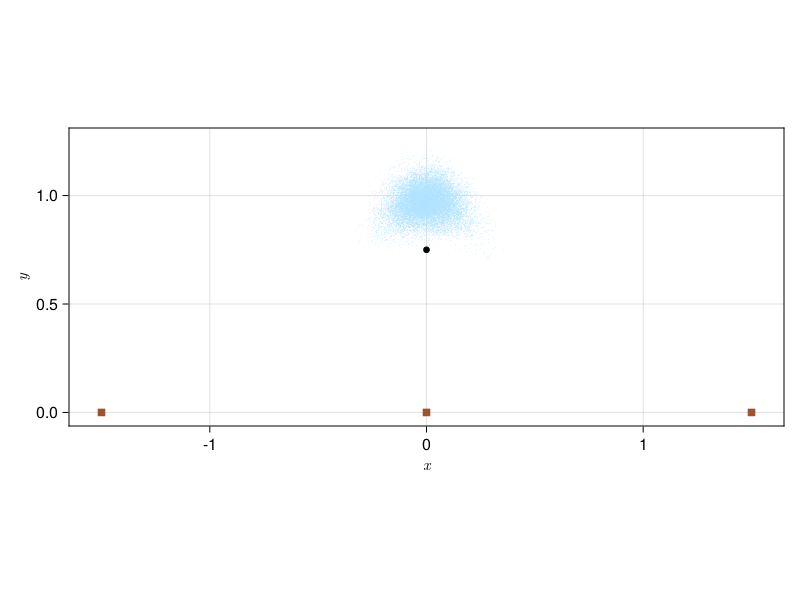

In [846]:
f = Figure()
ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
show_vortex_samples!(ax,x_data[1],obs,nskip=10,color=:lightskyblue1)
scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=8,color=:black,strokewidth=1)
plot_sensors!(ax,obs,color=:sienna)
f

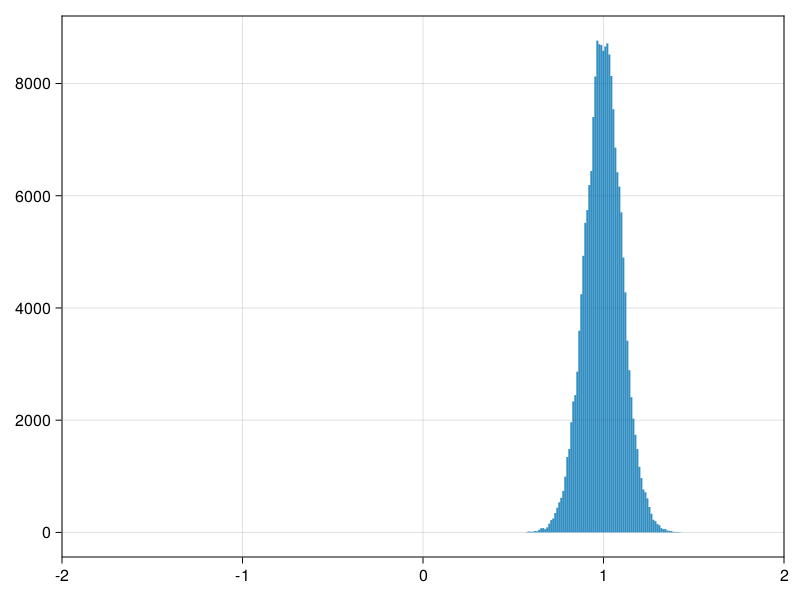

In [847]:
data_histogram(x_data[2][3,:])

In [848]:
gm = classify_by_gmm(1,x_data[1]);

In [849]:
weights(gm)

1-element Vector{Float64}:
 1.0

In [850]:
alpha_threshold = 0.15

0.15

In [851]:
Σ = covars(gm)[weights(gm).>alpha_threshold,:];
xm = transpose(means(gm)[weights(gm).>alpha_threshold,:])

3×1 transpose(::Matrix{Float64}) with eltype Float64:
 -0.0001300209044833938
  0.9655586558170398
  1.0047629860927758

In [852]:
Σ[1]

3×3 Matrix{Float64}:
 0.00810211  4.23168e-5  7.17071e-5
 4.23168e-5  0.00449076  0.00405982
 7.17071e-5  0.00405982  0.00398173

In [781]:
Σ[1]

3×3 Matrix{Float64}:
 0.00555458  4.5947e-5   5.40433e-5
 4.5947e-5   0.00182266  0.00209094
 5.40433e-5  0.00209094  0.00255459

In [778]:
#best_comp = 1;
#plot_vorticity(xm[:,best_comp],Σ[best_comp],obs,xlims=(-2,2),ylims=(-1,2))

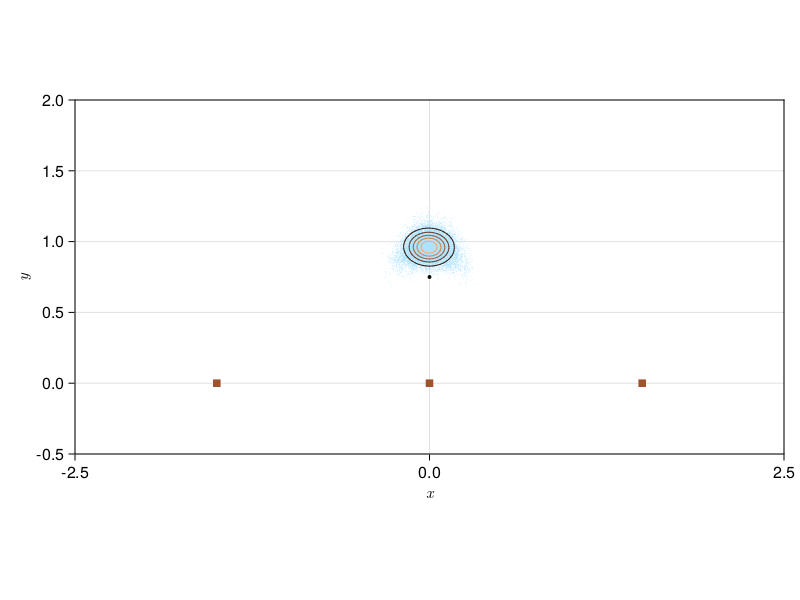

In [830]:
best_comp = 1;
f = Figure()
ax = f[1,1] = Axis(f;aspect=DataAspect(),xlabel=L"x",ylabel=L"y")
show_vortex_samples!(ax,x_data[1],obs,nskip=10,color=:lightskyblue1)
#vortex_ellipses!(ax,xm[:,best_comp],Σ[best_comp],obs)
#vortex_ellipses!(ax,xm,Σ,obs)
plot_vorticity!(ax,xm[:,best_comp],Σ[best_comp],obs,ylims=(-1,2),colormap=:copper)

scatter!(ax,real(truez),imag(truez),marker=:circle,markersize=4,color=:black,strokewidth=1)
plot_sensors!(ax,obs,color=:sienna)
ylims!(ax,(-0.5,2))
#save("samples-3vortex-3truth-7sensor-case1-mix2.pdf",f)
f

#### Plotting the basic data

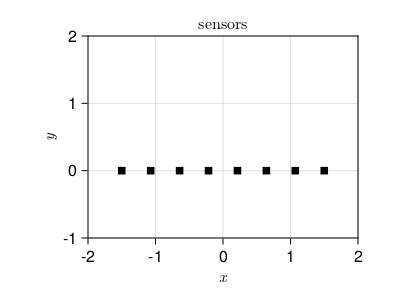

In [484]:
f = Figure(;resolution=(400,300))
ga = f[1, 1]

axleft = Axis(ga;xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
plot_sensors!(axleft,obs)

#save("basicdata-3sensor.pdf",f)

f

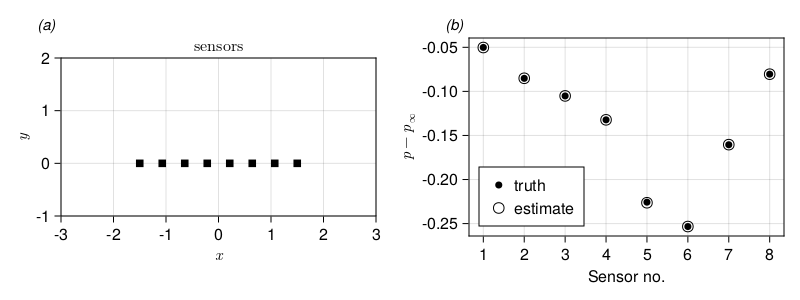

In [485]:
best_comp = 1

f = Figure(;resolution=(800,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()

axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-3,3,-1,2),aspect=DataAspect(),title=L"\textrm{sensors}")
plot_sensors!(axleft,obs)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty")
plot_sensor_data!(axcenter,ystar,xm[:,best_comp],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))
axislegend(axcenter,position=:lb)


for (label, layout) in zip(["(a)", "(b)"], [ga, gb])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("basicdata-1vortex-3sensor.pdf",f)

f

#### Plotting the pressure

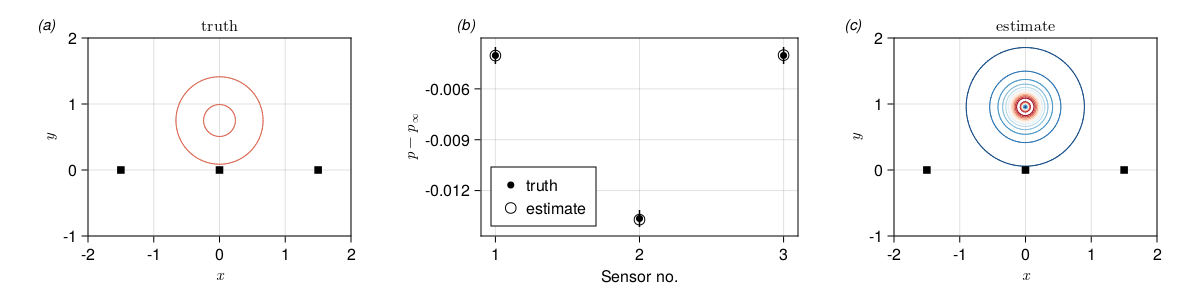

In [833]:
best_comp = 1

l = range(-0.5,0.01,length=21)
cl = (-0.5,0.01)
f = Figure(;resolution=(1200,300))
ga = f[1, 1] = GridLayout()
gb = f[1, 2] = GridLayout()
gc = f[1, 3] = GridLayout()
axleft = Axis(ga[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{truth}")
axright = Axis(gc[1,1];xlabel=L"x",ylabel=L"y",limits=(-2,2,-1,2),aspect=DataAspect(),title=L"\textrm{estimate}")
linkaxes!(axright,axleft)
plot_pressure_field!(axleft,x_true,obs_true)
plot_pressure_field!(axright,xm[:,best_comp],obs)

# Sensor plot
axcenter = Axis(gb[1,1];xticks=1:length(sens),xlabel="Sensor no.",ylabel=L"p-p_\infty") 
plot_sensor_data!(axcenter,ystar,xm[:,best_comp],t,obs;sensor_noise=ϵmeas*ones(length(ystar)))
axislegend(axcenter,position=:lb)


for (label, layout) in zip(["(a)", "(b)", "(c)"], [ga, gb, gc])
    Label(layout[1, 1, TopLeft()], label,
        textsize = 15,
        font = "TeX Heros Italic",
        padding = (0, 5, 5, 0),
        halign = :right)
end
#save("pressure-3vortex-3truth-7sensor-case1-mix2.pdf",f)

f